# Lesson 7: near real-time monitoring
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: Harmonized Landsat-Sentinel (HLS) datasets**

**Application: logging activities in Sichuan, China**


**Stochastic Continuous Change Detection (S-CCD)** incorporates the Kalman filter which eliminates the need to refit the entire time series whenever new data are ingested [1] . Instead, model coefficients (trend and seasonal parameters) are updated incrementally in a short-memory manner, so the algorithm does not retain the entire historical record. Once an observation is assimilated (or discarded), the raw data are no longer stored. This design makes the algorithm scalable for near real-time applications, where data arrive continuously.


*[1] Ye, S., Rogan, J., Zhu, Z., & Eastman, J. R. (2021). A near-real-time approach for monitoring forest disturbance using Landsat time series: Stochastic continuous change detection. Remote Sensing of Environment, 252, 112167.*

---

## Retrospective data processing
Let's use an HLS example from Sichuan to NRT monitoring logging activities 

To enable an NRT monitoring, we need run `sccd_detect` or `sccd_detect_flex` to process historical time-series datasets up to the current date. Assuming that we are at the date of "2024-04-04", we first need to process the historical HLS dataset from 2016 to today:

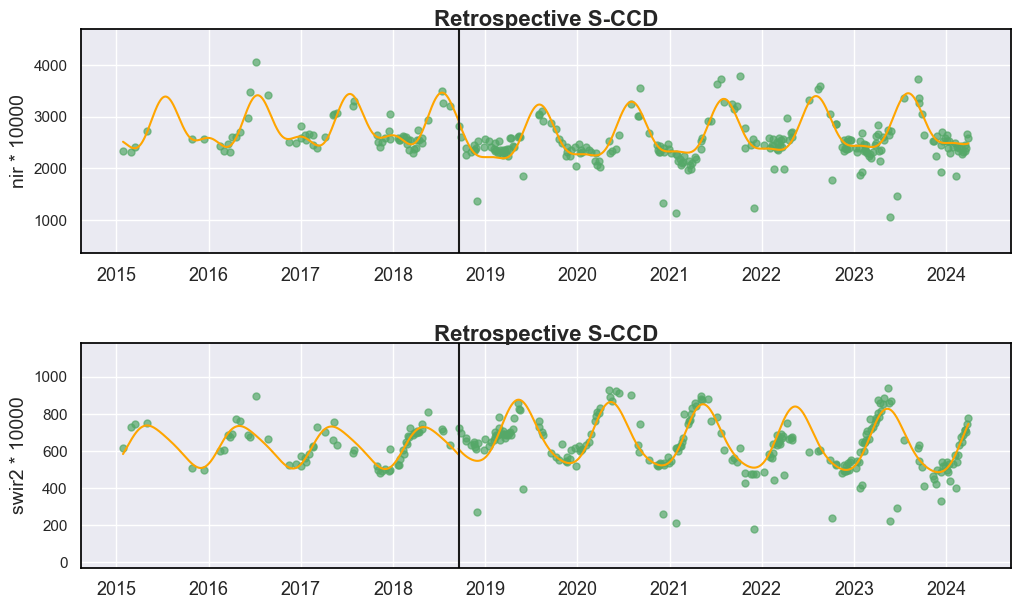

In [1]:
import numpy as np
import pathlib
import pandas as pd
from typing import List, Tuple, Dict, Union, Optional
from matplotlib.axes import Axes
import seaborn as sns
import matplotlib.pyplot as plt
from pyxccd import sccd_detect
from pyxccd.common import SccdOutput
from pyxccd.utils import getcategory_sccd, defaults

def display_sccd_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    for segment in sccd_result.rec_cg:
        j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
        if len(segment['coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': j * 0
            })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual']+
            plot_df['trimodal']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot near-real-time projection for SCCD if available
    if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
        recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
        j = np.arange(
            sccd_result.nrt_model['t_start_since1982'].item() + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
            recent_obs[-1].item()+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
            1
        )

        if len(sccd_result.nrt_model['nrt_coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': j * 0
            })
            
        plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    for i in range(len(sccd_result.rec_cg)):
        if getcategory_sccd(sccd_result.rec_cg, i) == 1:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)


TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '7_logging_hls_w0.csv'

# read example csv for HLS time series
data = pd.read_csv(in_path)

# split the array by the column
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.to_numpy().copy().T

# retrospective processing
sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas)

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="Retrospective S-CCD")

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="Retrospective S-CCD")

We could see a historical disturbance occurs in 2018, which is most likely due to a stress disturbance. But since this lesson is designed for NRT monitoring, we only focused the recent disturbance which is happening at the tail of the time series.

As briefly introduced in Lesson 1, `sccd_result` is an structured object, which contains six elements.

| Element | Datatype | Description |
| :------- | :------: | -------: |
| position   | int   | Position of current pixel, commonly coded as 10000*row+col   |
| rec_cg     | ndarray   | Temporal segment obtained by retrospective break detection  |
| nrt_mode   | int   | Current mode: the 1st digit indicate predictability and the 2nd is for `nrt_model` availability   |
| nrt_model  | ndarray   | Near real-time model for the last segment, which will be recursively updated|
| nrt_queue  | ndarray   | Near real-time observations stored in a queue when `nrt_model` is not initialized  |
| min_rmse   | ndarray   | Minimum rmse in CCDC to avoid overdetection from black body  |

Let's print the relevant `nrt_model` information at the current stage:

In [2]:
sccd_result

SccdOutput(position=1, rec_cg=array([(735625, 736954, 60, [[ 1.48542393e+04, -1.98632324e+02, -4.02296638e+01,  2.51553841e+01, -1.45135765e+01,  9.93953896e+00], [ 8.38789941e+03, -1.07453278e+02, -8.17535400e+01,  4.86201286e+01,  1.21395941e+01, -1.15295398e+00], [ 2.46381088e+02,  9.38574553e-01, -2.61588840e+01,  7.75747833e+01, -2.77891006e+01,  1.91563301e+01], [-4.81553398e+04,  6.92187561e+02, -4.14877747e+02, -2.82666321e+01,  1.99714539e+02, -4.93824234e+01], [ 2.35799585e+03, -1.30108614e+01, -1.74128586e+02,  1.30244141e+02,  2.11633873e+01,  1.98471394e+01], [ 6.30437939e+03, -7.71522598e+01, -5.81244240e+01,  9.30946274e+01, -1.19096756e+01,  1.11940117e+01]], [ 35.270123,  43.48861 ,  45.4437  , 163.38066 ,  83.16016 ,  46.84747 ], [  15.8222275,   26.901932 ,   28.303795 , -266.93457  ,  203.08496  ,  130.46231  ])],
      dtype={'names': ['t_start', 't_break', 'num_obs', 'coefs', 'rmse', 'magnitude'], 'formats': ['<i4', '<i4', '<i4', ('<f4', (6, 6)), ('<f4', (6,)), ('

In [3]:
# check if the current mode is still 1
print(f"The current nrt mode is {sccd_result.nrt_mode}")

# check the number of current anomlies
print(f"The current number of consecutive anomlies is {sccd_result.nrt_model['anomaly_conse']}")
recent_obs_date = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0][-1]

# check the last observation to be processed. Note that the observation date was formated the ordinal dates since the date of LANDSAT4_LAUNCH (723742) to save the date into int16. The user need to convert it to the formal date through the below code
print(f"The date of the last observations being processed is {pd.Timestamp.fromordinal(recent_obs_date.item() +defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'])}")

print(f"The observation number in the current segment is {sccd_result.nrt_model['num_obs']}")

The current nrt mode is 1
The current number of consecutive anomlies is 0
The date of the last observations being processed is 2024-03-29 00:00:00
The observation number in the current segment is 194


`nrt_mode = 1` means that this pixel is **currently in the NRT monitoring stage and has predictability**. `nrt_mode` has two digits.

First digit:

0 - has predictability

1 - has no predictability

Second digit:

0 - void mode, not intialized yet

1 - monitoring mode

2 - queue mode. Once the break is detected, the mode is transition from monitoring to queue mode

3 - monitoring mode for snow

4 - queue mode for snow

5 - transition mode from monitoring to queue mode (keep nrt_model and nrt_queue both), keeping 15 days since the break is first detected

Once an `anomaly` is detected but its change magnitude is only small-to-medium, no `break` is triggered. In this case, S-CCD may struggle to detect subsequent changes effectively, even though `sccd_result`retains an `nrt_model`. This limitation arises because the `anomaly` injects additional fluctuations into the `nrt_model`, reducing its stability.

To address this, S-CCD applies a predictability test with each new batch of observations. The test evaluates three consecutive observations, checking whether their residuals (differences from the predicted reflectance) fall below a threshold. The first digit of `nrt_mode` remains 1 until the predictability test is passed (then the first digit will be changed to 0).

The second digit encodes the availability of `nrt_model`. We used `1` and `3` to indicate the availability of `nrt_model` respectively in the normal and the snow scenario, and `2` and `4` to represent a lack of `nrt_model` and hence collecting observations until the CCDC initialization condition is reached (i.e., queue mode).

## Bi-weekly recursive update

### Week 1-2: found anomalies

Now let's perform incremental update of `sccd_result` with a step of two weeks. Let's read the first two weeks of observations since "2024-04-04", and update `sccd_result` using `sccd_update`:

The current nrt mode is 1
The current number of consecutive anomlies is 3
The observation number in the current segment is 197


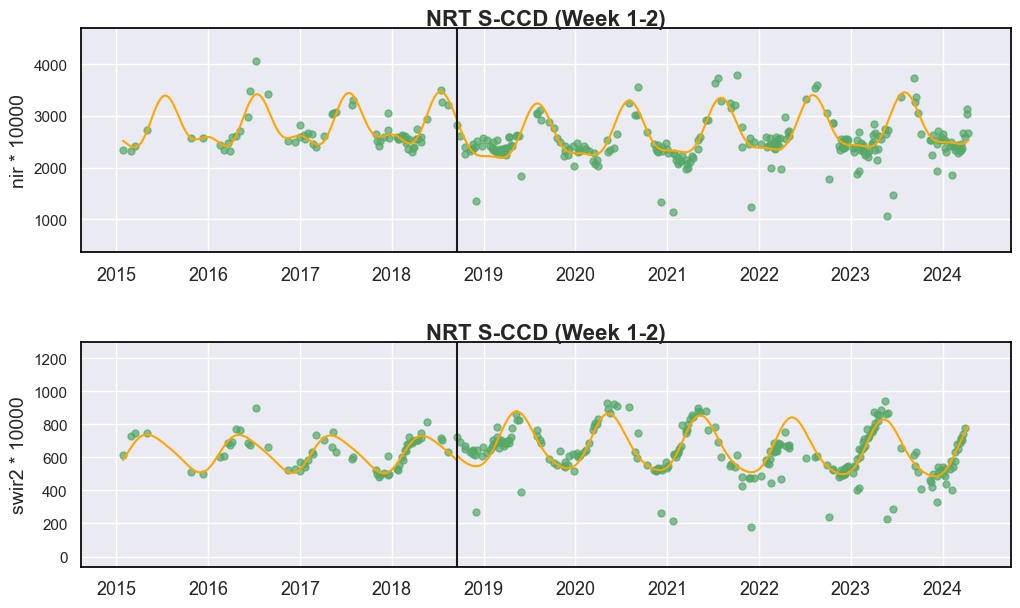

In [4]:
from pyxccd import sccd_update

TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '7_logging_hls_w12.csv'

# read example csv for HLS time series
data_1 = pd.read_csv(in_path)

# split the array by the column
dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, thermals1, qas1, sensor1 = data_1.to_numpy().copy().T
sccd_result = sccd_update(sccd_result, dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, qas1)

dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m, sensor_m = np.concatenate((data, data_1)).copy().T

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="NRT S-CCD (Week 1-2)")

display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="NRT S-CCD (Week 1-2)")

print(f"The current nrt mode is {sccd_result.nrt_mode}")
print(f"The current number of consecutive anomlies is {sccd_result.nrt_model['anomaly_conse']}")
print(f"The observation number in the current segment is {sccd_result.nrt_model['num_obs']}")

From the printed information, you can see that the number of consecutive anomalies jumps from 0 to 3, indicating that S-CCD has detected three anomalies within the most recent two weeks. These correspond to the three clear outliers at the tail of the above NIR and SWIR2 time series. The anomalies occurred because, after logging, all trees were removed from the surface, leading to increased reflectance in both almost all Landsat bands including NIR band (note that logging does not necessarily cause NIR reflectance to decrease).

At the same time, the observation count for the current segment increases from 194 to 197, confirming that three new observations have been processed and ingested into the segment during this two-week period. All three of these new observations are identified as spectral anomalies.

The sensitivity of anomaly detection can be tuned through the parameter `anomaly_pcg` in `sccd_update`. Its default value is 0.9, which corresponds to using the critical value of the chi-square distribution at the 90% probability level. Lowering this threshold makes the detector more sensitive (capturing weaker anomalies) but also increases the risk of false positives.

### Week 3-4: break detected!

The current nrt mode is 5
The current number of consecutive anamlies is 6
The observation number in the current segment is 200


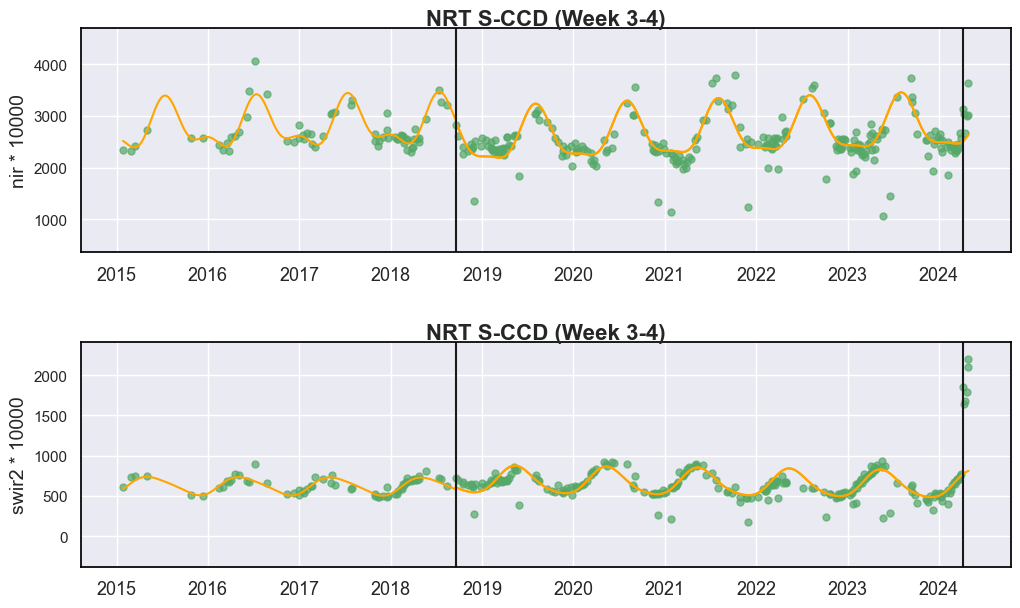

In [5]:

in_path = TUTORIAL_DATASET/ '7_logging_hls_w34.csv'

# read example csv for HLS time series
data_2 = pd.read_csv(in_path)

# split the array by the column
dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, thermals1, qas1, sensor1 = data_2.to_numpy().copy().T
sccd_result = sccd_update(sccd_result, dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, qas1)

dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m, sensor_m = np.concatenate((data, data_1, data_2)).copy().T

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="NRT S-CCD (Week 3-4)")

display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="NRT S-CCD (Week 3-4)")

print(f"The current nrt mode is {sccd_result.nrt_mode}")
print(f"The current number of consecutive anamlies is {sccd_result.nrt_model['anomaly_conse']}")
print(f"The observation number in the current segment is {sccd_result.nrt_model['num_obs']}")

The anomaly number continues to increase from 3 to 6, triggering a break detection. The nrt mode changed from `1` and `5`. `5` here means transitioning from 'monitoring' to 'queue', in which we will keep both `nrt_model` and `nrt_queue` for 15 days. So the user could still make break analysis from `nrt_model`. You could check the queue observation (since the break):

In [6]:
print(f"The observation queue is {sccd_result.nrt_queue}")

The observation queue is [([ 594,  832,  939, 3128, 3114, 1850], 15242)
 ([ 629,  831,  924, 3027, 2836, 1637], 15243)
 ([ 582,  790,  903, 2665, 2805, 1682], 15247)
 ([ 538,  810, 1054, 2996, 3046, 1787], 15257)
 ([ 747, 1026, 1270, 3644, 3740, 2197], 15259)
 ([ 695,  948, 1261, 3026, 3333, 2099], 15262)]


Let's make a quick check for the break type (1-disturbance; 2-recovery)

In [7]:
from pyxccd.utils import getcategory_sccd

print(f"The break category (1-disturbance; 2-recovery) is {getcategory_sccd(sccd_result.rec_cg, 1)}")
print(f"The recent disturbance date is {pd.Timestamp.fromordinal(sccd_result.rec_cg[-1]['t_break'])}")

The break category (1-disturbance; 2-recovery) is 1
The recent disturbance date is 2024-04-08 00:00:00



Finally, we plot the time-series Landsat images and Planet image of April. 15 to confirm the occurrence of disturbance: 


![](image1.png)

![](image2.png)

### Week 5-6: no clear observations

The current nrt mode is 5
The current number of consecutive anamlies is 6
The number of observation in the queue: 6
The observation queue is [([ 594,  832,  939, 3128, 3114, 1850], 15242)
 ([ 629,  831,  924, 3027, 2836, 1637], 15243)
 ([ 582,  790,  903, 2665, 2805, 1682], 15247)
 ([ 538,  810, 1054, 2996, 3046, 1787], 15257)
 ([ 747, 1026, 1270, 3644, 3740, 2197], 15259)
 ([ 695,  948, 1261, 3026, 3333, 2099], 15262)]


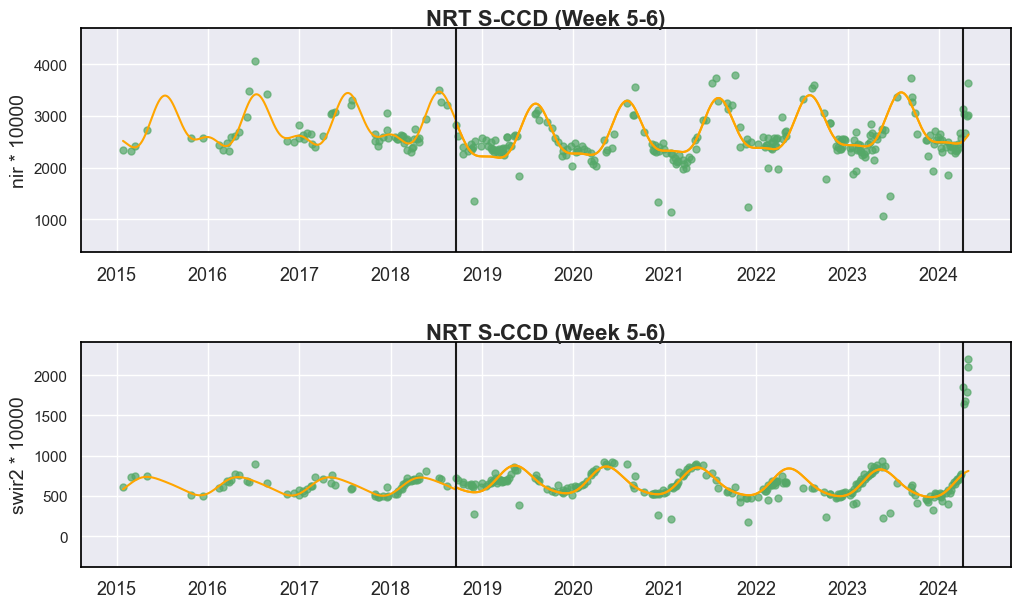

In [8]:
in_path = TUTORIAL_DATASET/ '7_logging_hls_w56.csv'

# read example csv for HLS time series
data_3 = pd.read_csv(in_path)

# split the array by the column
dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, thermals1, qas1, sensor1 = data_3.to_numpy().copy().T
sccd_result = sccd_update(sccd_result, dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, qas1)

dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m, sensor_m = np.concatenate((data, data_1, data_2, data_3)).copy().T

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="NRT S-CCD (Week 5-6)")

display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="NRT S-CCD (Week 5-6)")

print(f"The current nrt mode is {sccd_result.nrt_mode}")
print(f"The current number of consecutive anamlies is {sccd_result.nrt_model['anomaly_conse']}")
print(f"The number of observation in the queue: {len(sccd_result.nrt_queue)}")
print(f"The observation queue is {sccd_result.nrt_queue}")

For Weeks 5–6, no clear observations are available, so neither the `nrt_model` nor the `nrt_queue` is updated. Such cases occasionally occur in an NRT application when no valid observations are acquired. In this situation, monitoring is temporarily halted; however, the most recent break information can still be retrieved from the `sccd_result`.

### Week 7-8: collecting observations continuously after the break (6->8)

The current nrt mode is 5
The current number of consecutive anamlies is 6
The number of observation in the queue: 8


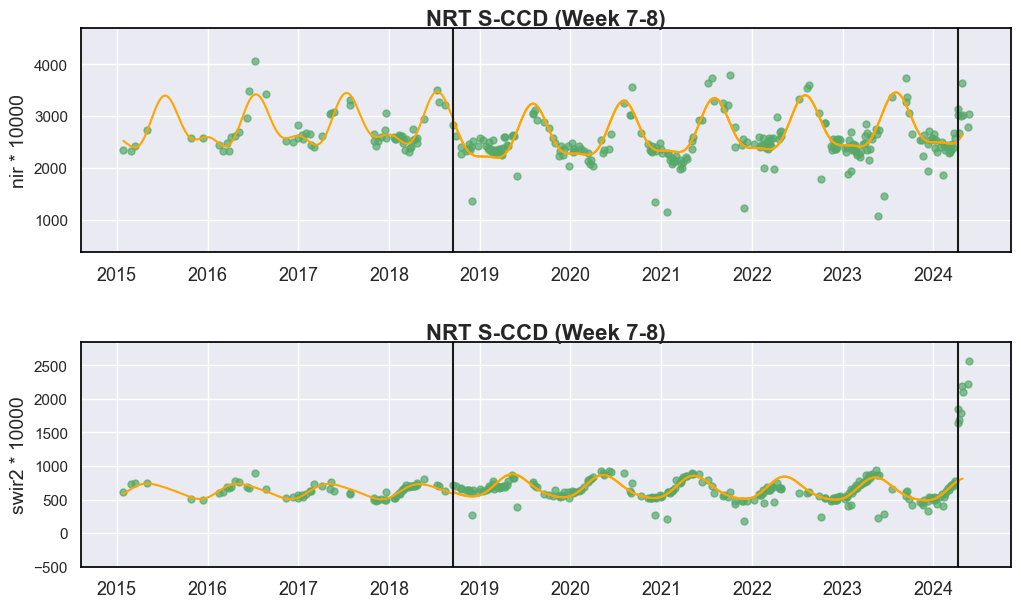

In [9]:

in_path = TUTORIAL_DATASET/ '7_logging_hls_w78.csv'

# read example csv for HLS time series
data_4 = pd.read_csv(in_path)

# split the array by the column
dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, thermals1, qas1, sensor1 = data_4.to_numpy().copy().T
sccd_result = sccd_update(sccd_result, dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, qas1)

dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m, sensor_m = np.concatenate((data, data_1, data_2, data_3, data_4)).copy().T

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="NRT S-CCD (Week 7-8)")

display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="NRT S-CCD (Week 7-8)")

print(f"The current nrt mode is {sccd_result.nrt_mode}")
print(f"The current number of consecutive anamlies is {sccd_result.nrt_model['anomaly_conse']}")
print(f"The number of observation in the queue: {len(sccd_result.nrt_queue)}")

### Week 9-12: irregular-interval monitoring

`S-CCD` allows you to input any length of new observations during the NRT scenario. For example, if monitoring was paused for two weeks, you may resume by running the monitoring with four weeks of observations at once.

In this case, note that `nrt_mode` changed from `5` to `12`. A value of `12` indicates the queue mode (with unpredictability). From this point onward, `S-CCD` begins to collect new observations until the CCDC initialization conditions are satisfied again. During this stage, the `nrt_queue` stores the incoming observations while the nrt_model is set to None.

The transitioning mode (`nrt_mode = 5`) is only retained for 15 days before switching to the queue mode.

The current nrt mode is 12
nrt_model is []
The number of observation in the queue: 9


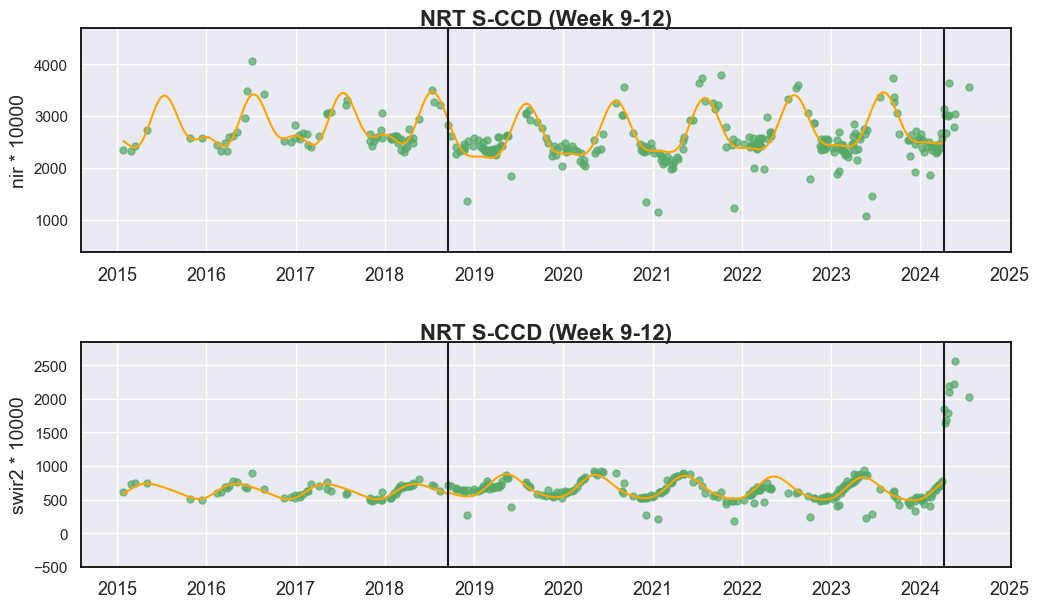

In [10]:
in_path = TUTORIAL_DATASET/ '7_logging_hls_w910.csv'

# read example csv for HLS time series
data_5 = pd.read_csv(in_path)

# split the array by the column
dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, thermals1, qas1, sensor1 = data_5.to_numpy().copy().T
sccd_result = sccd_update(sccd_result, dates1, blues1, greens1, reds1, nirs1, swir1s1, swir2s1, qas1)

dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m, sensor_m = np.concatenate((data, data_1, data_2, data_3, data_4, data_5)).copy().T

# plot time series and detection results
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.4)


# Let's plot NIR and SWIR2 time series, which are the best two disturbance indicator bands
display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, sccd_result=sccd_result, axe=axes[0], title="NRT S-CCD (Week 9-12)")

display_sccd_result(data=np.stack((dates_m, blues_m, greens_m, reds_m, nirs_m, swir1s_m, swir2s_m, thermals_m, qas_m), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=5, sccd_result=sccd_result, axe=axes[1], title="NRT S-CCD (Week 9-12)")


print(f"The current nrt mode is {sccd_result.nrt_mode}")
print(f"nrt_model is {sccd_result.nrt_model}")
print(f"The number of observation in the queue: {len(sccd_result.nrt_queue)}")


## Summary

From the above case, I demonstrated how S-CCD detects breaks in a recursive manner. In practice, users may save the `sccd_result` locally instead of storing full time-series images, which reduces data storage requirements by approximately 90% and thus enables large-area processing.

It is worth noting that although the break in Week 3–4 was confirmed with six consecutive anomalies, `S-CCD` had already begun outputting anomalies as early as Week 1–2. A more advanced approach is to apply machine learning techniques to features extracted from the nrt_model, which allows for earlier disturbance detection using fewer than six consecutive anomalies. For details, please refer to the machine-learning framework presented in [2].


*[2] Ye, S., Zhu, Z., & Suh, J. W. (2024). Leveraging past information and machine learning to accelerate land disturbance monitoring. Remote Sensing of Environment, 305, 114071.*
